In [0]:
import pandas as pd

In [0]:
df = pd.read_csv('data.csv')
df.head()

,Unnamed: 0,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,0,128202,456,1,Homer Simpson: (CHUCKLES) Thanks to our new G....,92000,True,2,29.0,Homer Simpson,Homer's Car,"Thanks to our new G.P.S., I'll have you at sch...",thanks to our new gps ill have you at school i...,13.0
1,1,128204,456,3,Homer Simpson: (ANGUISHED MOAN) Meters?,99000,True,2,29.0,Homer Simpson,Homer's Car,Meters?,meters,1.0
2,2,128205,456,4,"Lisa Simpson: Dad, a meter is three inches lon...",100000,True,9,29.0,Lisa Simpson,Homer's Car,"Dad, a meter is three inches longer than a yar...",dad a meter is three inches longer than a yard...,22.0
3,3,128207,456,6,"Bart Simpson: Dad, no! That takes us into a co...",113000,True,8,29.0,Bart Simpson,Homer's Car,"Dad, no! That takes us into a construction site!",dad no that takes us into a construction site,9.0
4,4,128208,456,7,Homer Simpson: Stupid kid. Thinks he's smarter...,115000,True,2,29.0,Homer Simpson,Homer's Car,Stupid kid. Thinks he's smarter than a computer.,stupid kid thinks hes smarter than a computer,8.0


In [0]:
df = df[df['raw_character_text'].isin(('Lisa Simpson', 'Bart Simpson'))]

In [0]:
df.head()

,Unnamed: 0,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
2,2,128205,456,4,"Lisa Simpson: Dad, a meter is three inches lon...",100000,True,9,29.0,Lisa Simpson,Homer's Car,"Dad, a meter is three inches longer than a yar...",dad a meter is three inches longer than a yard...,22.0
3,3,128207,456,6,"Bart Simpson: Dad, no! That takes us into a co...",113000,True,8,29.0,Bart Simpson,Homer's Car,"Dad, no! That takes us into a construction site!",dad no that takes us into a construction site,9.0
7,7,128214,456,13,"Bart Simpson: Thanks for the ride! / Bye, Dad!",144000,True,8,29.0,Bart Simpson,Homer's Car,"Thanks for the ride! / Bye, Dad!",thanks for the ride bye dad,6.0
9,9,128222,456,21,Bart Simpson: Where's Mrs. K.?,151000,True,8,573.0,Bart Simpson,Mrs. Krabappel's Classroom,Where's Mrs. K.?,wheres mrs k,3.0
11,11,128224,456,23,"Bart Simpson: So, who's gonna take her place? ...",182000,True,8,573.0,Bart Simpson,Mrs. Krabappel's Classroom,"So, who's gonna take her place? Me, I hope?",so whos gonna take her place me i hope,9.0


In [0]:
df = df[~df['normalized_text'].isna()]

In [0]:
df.head()

,Unnamed: 0,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
2,2,128205,456,4,"Lisa Simpson: Dad, a meter is three inches lon...",100000,True,9,29.0,Lisa Simpson,Homer's Car,"Dad, a meter is three inches longer than a yar...",dad a meter is three inches longer than a yard...,22.0
3,3,128207,456,6,"Bart Simpson: Dad, no! That takes us into a co...",113000,True,8,29.0,Bart Simpson,Homer's Car,"Dad, no! That takes us into a construction site!",dad no that takes us into a construction site,9.0
7,7,128214,456,13,"Bart Simpson: Thanks for the ride! / Bye, Dad!",144000,True,8,29.0,Bart Simpson,Homer's Car,"Thanks for the ride! / Bye, Dad!",thanks for the ride bye dad,6.0
9,9,128222,456,21,Bart Simpson: Where's Mrs. K.?,151000,True,8,573.0,Bart Simpson,Mrs. Krabappel's Classroom,Where's Mrs. K.?,wheres mrs k,3.0
11,11,128224,456,23,"Bart Simpson: So, who's gonna take her place? ...",182000,True,8,573.0,Bart Simpson,Mrs. Krabappel's Classroom,"So, who's gonna take her place? Me, I hope?",so whos gonna take her place me i hope,9.0


In [0]:
X, y = df['normalized_text'].tolist(), df['raw_character_text'].tolist()

## Работаем с выборкой

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
from sklearn.preprocessing import LabelEncoder
l = LabelEncoder()
y_train = l.fit_transform(y_train)
y_test = l.transform(y_test)

In [0]:
text = ' '.join(X_train)

In [0]:
ALL_WORDS = set(text.split(' '))

In [0]:
len(ALL_WORDS)

13965

In [0]:
from collections import Counter

In [0]:
c = Counter(text.split(' '))
c.most_common(10)

[('the', 4977),
 ('i', 4911),
 ('you', 4780),
 ('a', 4010),
 ('to', 3425),
 ('and', 2297),
 ('it', 1955),
 ('of', 1887),
 ('is', 1657),
 ('dad', 1569)]

In [0]:
WORDS_COUNT = 2000

In [0]:
ALL_WORDS = set([w for w, _ in c.most_common(WORDS_COUNT)])

In [0]:
INDEX_TO_WORD = ['<pad>', '<miss>'] + list(ALL_WORDS)

In [0]:
len(INDEX_TO_WORD)


2002

In [0]:
WORD_TO_INDEX = {w: i for i, w in enumerate(INDEX_TO_WORD)}

In [0]:
INDEX_TO_WORD[:10]

['<pad>',
 '<miss>',
 'ugh',
 'shelbyville',
 'surprise',
 'truly',
 'people',
 'hard',
 'between',
 'beg']

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([2.949e+03, 1.405e+03, 3.032e+03, 1.466e+03, 2.560e+03, 9.540e+02,
        1.625e+03, 7.260e+02, 1.165e+03, 4.440e+02, 6.920e+02, 3.000e+02,
        4.780e+02, 1.680e+02, 2.810e+02, 1.270e+02, 1.650e+02, 6.700e+01,
        9.900e+01, 4.000e+01, 7.200e+01, 2.800e+01, 3.800e+01, 1.800e+01,
        1.400e+01, 2.200e+01, 1.200e+01, 1.600e+01, 9.000e+00, 8.000e+00,
        2.000e+00, 1.000e+01, 2.000e+00, 5.000e+00, 1.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 4.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([ 1.  ,  2.48,  3.96,  5.44,  6.92,  8.4 ,  9.88, 11.36, 12.84,
        14.32, 15.8 , 17.28, 18.76, 20.24, 21.72, 23.2 , 24.68, 26.16,
        27.64, 29.12, 30.6 , 32.08, 33.56, 35.04, 36.52, 38.  , 39.48,
        40.96, 42.44, 43.92, 45.4 , 46.88, 48.36, 49.84, 51.32, 52.8 ,
        54.28, 55.76, 57.24, 58.72, 60.2 , 61.68, 63.16, 64.64, 66.12,
        67.6 , 69.08,

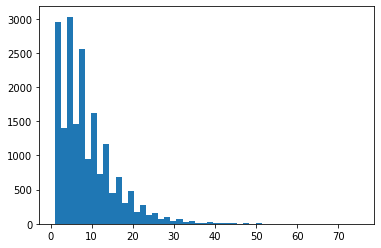

In [0]:
plt.hist([len(s.split(' ')) for s in X_train], bins=50)

## Формируем датасеты

In [0]:
MAX_LEN = 20

In [0]:
import torch

In [0]:
train_data = torch.zeros((len(X_train), MAX_LEN), dtype=int)
test_data = torch.zeros((len(X_test), MAX_LEN), dtype=int)

In [0]:
for i in range(len(X_train)):
  for j, w in enumerate(X_train[i].split(' ')):
    if j >= MAX_LEN:
      break
    train_data[i, j] = WORD_TO_INDEX.get(w, WORD_TO_INDEX['<miss>'])

In [0]:
for i in range(len(X_test)):
  for j, w in enumerate(X_test[i].split(' ')):
    if j >= MAX_LEN:
      break
    test_data[i, j] = WORD_TO_INDEX.get(w, WORD_TO_INDEX['<miss>'])

In [0]:
train_dataset = torch.utils.data.TensorDataset(train_data, torch.LongTensor(y_train))
test_dataset = torch.utils.data.TensorDataset(test_data, torch.LongTensor(y_test))

In [0]:
BATCH_SIZE = 128

In [0]:
train = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test = torch.utils.data.DataLoader(test_dataset, BATCH_SIZE, shuffle=False)

In [0]:
dev = torch.device('cuda')

## Модель

In [0]:
from torch import nn

In [0]:
class VanilaModel(nn.Module):
  def __init__(self, dict_size, embed_size, num_hiddens, num_classes):
    super().__init__()

    self.num_hiddens = num_hiddens
    self.embed = nn.Embedding(dict_size, embed_size)
    self.rnn = nn.RNN(embed_size, num_hiddens, batch_first=True)
    self.output = nn.Linear(num_hiddens, num_classes)

  def forward(self, X):
    output = self.embed(X)
    y, s = self.rnn(output)
    return self.output(s[0])

In [0]:
class GRUModel(nn.Module):
  def __init__(self, dict_size, embed_size, num_hiddens, num_classes):
    super().__init__()

    self.num_hiddens = num_hiddens
    self.embed = nn.Embedding(dict_size, embed_size)
    self.rnn = nn.GRU(embed_size, num_hiddens, batch_first=True)
    self.output = nn.Linear(num_hiddens, num_classes)

  def forward(self, X):
    output = self.embed(X)
    y, s = self.rnn(output)
    return self.output(s[0])

In [0]:
class LSTMModel(nn.Module):
  def __init__(self, dict_size, embed_size, num_hiddens, num_classes):
    super().__init__()

    self.num_hiddens = num_hiddens
    self.embed = nn.Embedding(dict_size, embed_size)
    self.rnn = nn.LSTM(embed_size, num_hiddens, batch_first=True)
    self.output = nn.Linear(num_hiddens, num_classes)

  def forward(self, X):
    output = self.embed(X)
    y, s = self.rnn(output)
    return self.output(s[0][0])

In [0]:
class UberModel(nn.Module):
  def __init__(self, dict_size, embed_size, num_hiddens, num_classes):
    super().__init__()

    self.num_hiddens = num_hiddens
    self.embed = nn.Embedding(dict_size, embed_size)
    self.rnn = nn.GRU(embed_size, num_hiddens, batch_first=True, num_layers=2)
    self.hidden = nn.Linear(num_hiddens, num_classes)

  def forward(self, X):
    output = self.embed(X)
    y, s = self.rnn(output)
    h = self.hidden(s[0])
    return h

In [0]:
model = VanilaModel(len(INDEX_TO_WORD), 300, 256, 2)

In [0]:
for X, y in train:
  break

In [0]:
model(X).shape

torch.Size([128, 2])

## Обучение

In [0]:
import time

In [0]:
def validate_acc(model, dataset, dev):
  loss = nn.CrossEntropyLoss(reduction='sum')
  loss_acc, passed, correct = 0., 0, 0
  for X, y in dataset:
    X = X.to(dev)
    y = y.to(dev)

    output = model(X)
    l = loss(output, y)

    loss_acc += l.item()
    correct += (output.argmax(dim=1) == y).sum().item()
    passed += len(y)

  return loss_acc / passed, correct / passed

In [0]:
def train_model(model, train_dl, test_dl, trainer, dev, num_epochs=25):
  loss = nn.CrossEntropyLoss(reduction='sum')
  for ep in range(num_epochs):
    ep_start, tloss_acc, tpassed, tcorrect = time.time(), 0., 0, 0
    for X, y in train_dl:
      X, y = X.to(dev), y.to(dev)
      trainer.zero_grad()

      output = model(X)
      l = loss(output, y)
      l.backward()
      trainer.step()

      tloss_acc += l.item()
      tcorrect += (output.argmax(dim=1) == y).sum().item()
      tpassed += len(y)
    
    test_loss, test_acc = validate_acc(model, test_dl, dev)

    print('Epoch {}. Taked {:.3f} sec. Train loss: {:.3f}, Train acc {:.3f}, Test  Loss {:.3f}, Test Acc {:.3f}'.format(
        ep, time.time() - ep_start, tloss_acc / tpassed, tcorrect / tpassed, test_loss, test_acc
    ))

## Эксперимент

In [0]:
model = VanilaModel(len(INDEX_TO_WORD), 300, 256, 2).to(dev)
trainer = torch.optim.SGD(model.parameters(), lr=0.01)
train_model(model, train, test, trainer, dev)

Epoch 0. Taked 1.364 sec. Train loss: 69.529, Train acc 0.508, Test  Loss 30.915, Test Acc 0.563
Epoch 1. Taked 1.332 sec. Train loss: 73.412, Train acc 0.500, Test  Loss 34.554, Test Acc 0.560
Epoch 2. Taked 1.292 sec. Train loss: 72.868, Train acc 0.498, Test  Loss 57.887, Test Acc 0.557
Epoch 3. Taked 1.304 sec. Train loss: 71.748, Train acc 0.503, Test  Loss 66.389, Test Acc 0.444
Epoch 4. Taked 1.273 sec. Train loss: 70.431, Train acc 0.510, Test  Loss 44.452, Test Acc 0.556
Epoch 5. Taked 1.277 sec. Train loss: 70.772, Train acc 0.508, Test  Loss 9.375, Test Acc 0.560
Epoch 6. Taked 1.277 sec. Train loss: 72.025, Train acc 0.505, Test  Loss 16.717, Test Acc 0.559
Epoch 7. Taked 1.302 sec. Train loss: 71.007, Train acc 0.509, Test  Loss 43.482, Test Acc 0.559
Epoch 8. Taked 1.269 sec. Train loss: 68.737, Train acc 0.515, Test  Loss 42.639, Test Acc 0.554
Epoch 9. Taked 1.278 sec. Train loss: 71.305, Train acc 0.507, Test  Loss 81.320, Test Acc 0.559
Epoch 10. Taked 1.299 sec. Trai

In [0]:
model = GRUModel(len(INDEX_TO_WORD), 300, 256, 2).to(dev)
trainer = torch.optim.SGD(model.parameters(), lr=0.01)
train_model(model, train, test, trainer, dev)

Epoch 0. Taked 1.730 sec. Train loss: 13.687, Train acc 0.506, Test  Loss 3.895, Test Acc 0.575
Epoch 1. Taked 1.609 sec. Train loss: 7.067, Train acc 0.532, Test  Loss 2.154, Test Acc 0.572
Epoch 2. Taked 1.626 sec. Train loss: 4.711, Train acc 0.571, Test  Loss 2.741, Test Acc 0.564
Epoch 3. Taked 1.597 sec. Train loss: 3.983, Train acc 0.604, Test  Loss 2.227, Test Acc 0.583
Epoch 4. Taked 1.607 sec. Train loss: 3.329, Train acc 0.636, Test  Loss 2.934, Test Acc 0.583
Epoch 5. Taked 1.612 sec. Train loss: 2.480, Train acc 0.680, Test  Loss 2.652, Test Acc 0.594
Epoch 6. Taked 1.592 sec. Train loss: 1.834, Train acc 0.734, Test  Loss 2.827, Test Acc 0.596
Epoch 7. Taked 1.609 sec. Train loss: 1.196, Train acc 0.779, Test  Loss 3.139, Test Acc 0.612
Epoch 8. Taked 1.601 sec. Train loss: 0.821, Train acc 0.822, Test  Loss 2.577, Test Acc 0.600
Epoch 9. Taked 1.611 sec. Train loss: 0.521, Train acc 0.861, Test  Loss 2.647, Test Acc 0.602
Epoch 10. Taked 1.641 sec. Train loss: 0.296, Tra

In [0]:
model = LSTMModel(len(INDEX_TO_WORD), 300, 256, 2).to(dev)
trainer = torch.optim.SGD(model.parameters(), lr=0.01)
train_model(model, train, test, trainer, dev)

Epoch 0. Taked 1.949 sec. Train loss: 0.908, Train acc 0.523, Test  Loss 0.690, Test Acc 0.557
Epoch 1. Taked 1.782 sec. Train loss: 0.679, Train acc 0.560, Test  Loss 0.685, Test Acc 0.573
Epoch 2. Taked 1.805 sec. Train loss: 0.654, Train acc 0.610, Test  Loss 0.676, Test Acc 0.597
Epoch 3. Taked 1.813 sec. Train loss: 0.632, Train acc 0.635, Test  Loss 0.670, Test Acc 0.611
Epoch 4. Taked 1.776 sec. Train loss: 0.615, Train acc 0.657, Test  Loss 0.684, Test Acc 0.601
Epoch 5. Taked 1.797 sec. Train loss: 0.600, Train acc 0.663, Test  Loss 0.689, Test Acc 0.615
Epoch 6. Taked 1.786 sec. Train loss: 0.587, Train acc 0.671, Test  Loss 0.703, Test Acc 0.595
Epoch 7. Taked 1.794 sec. Train loss: 0.572, Train acc 0.684, Test  Loss 0.701, Test Acc 0.599
Epoch 8. Taked 1.787 sec. Train loss: 0.557, Train acc 0.695, Test  Loss 0.721, Test Acc 0.613
Epoch 9. Taked 1.767 sec. Train loss: 0.544, Train acc 0.707, Test  Loss 0.718, Test Acc 0.618
Epoch 10. Taked 1.781 sec. Train loss: 0.533, Trai

In [0]:
model = UberModel(len(INDEX_TO_WORD), 150, 128, 2).to(dev)
trainer = torch.optim.SGD(model.parameters(), lr=0.01)
train_model(model, train, test, trainer, dev)

Epoch 0. Taked 1.433 sec. Train loss: 5.563, Train acc 0.511, Test  Loss 1.361, Test Acc 0.559
Epoch 1. Taked 1.284 sec. Train loss: 3.488, Train acc 0.513, Test  Loss 1.092, Test Acc 0.562
Epoch 2. Taked 1.299 sec. Train loss: 2.575, Train acc 0.538, Test  Loss 1.340, Test Acc 0.574
Epoch 3. Taked 1.260 sec. Train loss: 2.206, Train acc 0.554, Test  Loss 1.165, Test Acc 0.588
Epoch 4. Taked 1.255 sec. Train loss: 1.861, Train acc 0.575, Test  Loss 1.166, Test Acc 0.601
Epoch 5. Taked 1.262 sec. Train loss: 1.576, Train acc 0.613, Test  Loss 1.135, Test Acc 0.588
Epoch 6. Taked 1.251 sec. Train loss: 1.377, Train acc 0.639, Test  Loss 1.381, Test Acc 0.603
Epoch 7. Taked 1.262 sec. Train loss: 1.198, Train acc 0.675, Test  Loss 1.267, Test Acc 0.593
Epoch 8. Taked 1.257 sec. Train loss: 0.881, Train acc 0.725, Test  Loss 1.262, Test Acc 0.600
Epoch 9. Taked 1.262 sec. Train loss: 0.688, Train acc 0.766, Test  Loss 1.325, Test Acc 0.598
Epoch 10. Taked 1.274 sec. Train loss: 0.480, Trai